In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn import impute
from sklearn import model_selection, preprocessing, decomposition, cluster, metrics
import scikitplot as skplt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings('ignore')

# 1

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [3]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
float_type_count = 0
object_type_count = 0
for i in data:
    if data[i].dtype == float:
        float_type_count += 1
    if data[i].dtype == object:
        object_type_count += 1
print(f'float: {float_type_count}, object: {object_type_count}')

float: 62, object: 5


# 2

После выбора значимых атрибутов необхоимо будет думать - как их сгладить

In [57]:
columns = ['total_cases', 'new_cases', 'new_cases_smoothed', 
           'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million']
data[columns].tail(8)

,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million
181945,247297.0,0.0,29.000,16385.780,0.000,1.922
181946,247336.0,39.0,25.143,16388.365,2.584,1.666
181947,247383.0,47.0,25.000,16391.479,3.114,1.656
181948,247488.0,105.0,35.857,16398.436,6.957,2.376
181949,247524.0,36.0,41.000,16400.821,2.385,2.717
181950,247524.0,0.0,35.143,16400.821,0.000,2.329
181951,247598.0,74.0,43.000,16405.725,4.903,2.849
181952,247667.0,69.0,52.857,16410.296,4.572,3.502


In [59]:
data[columns].tail(7)['new_cases_per_million'].sum() / 7

3.5021428571428572

In [71]:
data[columns]['total_cases_per_million'].values[-1:] * data['population'].values[-1:]

array([2.47666993e+11])

Будем предсказывать 'new_cases_smoothed_per_million', из которого можно вывести 'total_cases_per_million', и путем умножения на 'population' страны 'total_cases'.
'new_cases_smoothed_per_million' - дает сглаженную оценку за неделю, из-за чего значения меньше колеблятся
Аналогично с 'total_deaths'

<AxesSubplot:>

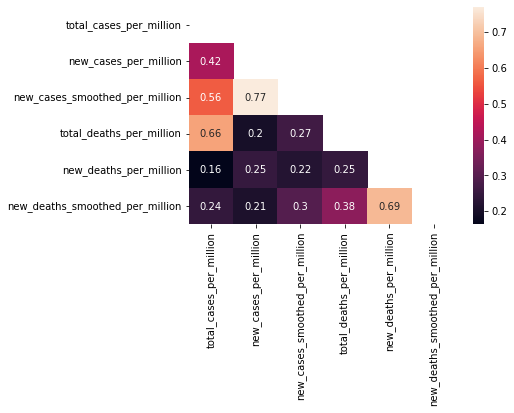

In [87]:
columns = ['total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million',
          'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million']
sns.heatmap(data[columns].corr(), annot=True, mask=np.triu(data[columns].corr()))

### Вывод:

**'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million'** - целевые функции. Также используя их, можно вывести другие показатели

Показатели 'excess_mortality', 'excess_mortality_cumulative', 
 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative_per_million' отвечают за стаистику прогнозируемых и фактических смертей и не имеют отношения к решваемой задаче

In [58]:
columns = ['icu_patients_per_million', 'hosp_patients_per_million', 
           'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million']
data.groupby('location')[columns].mean().head(10)

,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million
location,,,,
Afghanistan,NaN,NaN,NaN,NaN
Africa,NaN,NaN,NaN,NaN
Albania,NaN,NaN,NaN,NaN
Algeria,0.624385,NaN,NaN,NaN
Andorra,NaN,NaN,NaN,NaN
Angola,NaN,NaN,NaN,NaN
Anguilla,NaN,NaN,NaN,NaN
Antigua and Barbuda,NaN,NaN,NaN,NaN
Argentina,64.346691,NaN,NaN,NaN


Рассмотрим другие признаки:

In [57]:
columns = ['location', 'date', 'population_density', 'extreme_poverty', 
           'handwashing_facilities', 'hospital_beds_per_thousand']
for i in columns[2:]:
    print(i, '~', int(data.groupby('location')[i].mean().isna().sum() / len(pd.unique(data.location)) * 100), '%')

population_density ~ 12 %
extreme_poverty ~ 48 %
handwashing_facilities ~ 60 %
hospital_beds_per_thousand ~ 29 %


Интересное наблюдение - чем больше доля нищих людей, тем ниже доля людей, имеющих базовые средства гигиены

<AxesSubplot:>

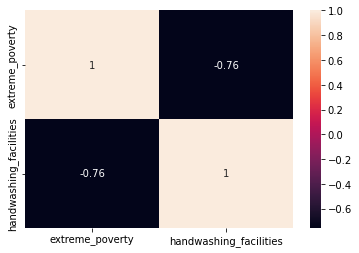

In [65]:
sns.heatmap(data[['extreme_poverty', 'handwashing_facilities']].corr(), annot=True)

In [95]:
data[data.location=='Russia'][['location', 'extreme_poverty', 
                               'handwashing_facilities', 'hospital_beds_per_thousand']].head()

,location,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand
135340,Russia,0.1,NaN,8.05
135341,Russia,0.1,NaN,8.05
135342,Russia,0.1,NaN,8.05
135343,Russia,0.1,NaN,8.05
135344,Russia,0.1,NaN,8.05


Видно, что лишь часть стран имеет указанные признаки

### Вывод

Удалим **handwashing_facilities**, а также все страны, не имеющие таких атрибутов, как **['population_density', 'extreme_poverty', 'handwashing_facilities', 'hospital_beds_per_thousand']**, также статистики **['icu_patients_per_million', 'hosp_patients_per_million','weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million']**

Уровень серьезности реагирования правительства:

In [74]:
print('Отсутсвует ~',
      int(data.groupby('location')[['stringency_index']].mean().isna().sum()
          / len(pd.unique(data.location)) * 100), '% стран')

Отсутсвует ~ 23 % стран


Скорость распространения вируса

In [75]:
print('Отсутсвует ~',
      int(data.groupby('location')[['reproduction_rate']].mean().isna().sum()
          / len(pd.unique(data.location)) * 100), '% стран')

Отсутсвует ~ 21 % стран


Количество проведенных тестов нас мало интересует, так как это не влияет на распространение короновируса.
Рассмоторим долю положительный результатов

<AxesSubplot:xlabel='location', ylabel='date'>

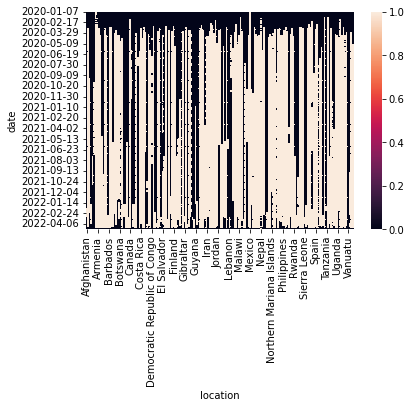

In [14]:
sns.heatmap(~pd.pivot_table(data=data, index='date', columns='location', values='positive_rate').isna())

In [77]:
print('Отсутсвует ~',
      int(data.groupby('location')[['positive_rate']].mean().isna().sum()
          / len(pd.unique(data.location)) * 100), '% стран')

Отсутсвует ~ 29 % стран


In [93]:
dt = data.groupby('location')[['positive_rate']].mean()
dt[~dt.isna().values].index.tolist()[:10]

['Afghanistan',
 'Albania',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria']

In [91]:
data[data.location=='Turkey'][['date', 'positive_rate']].dropna().head()

,date,positive_rate
166204,2020-04-03,0.1621
166205,2020-04-04,0.1561
166206,2020-04-05,0.1539
166207,2020-04-06,0.1541
166208,2020-04-07,0.1577


Использовать Vaccinations нельзя, так как в данном случае, необходимо предсказать 'total_vaccinations_per_hundred'.

### Вывод

Удалить страны, у которых отсутсвует **positive_rate, stringency_index, reproduction_rate, total_vaccinations_per_hundred**

In [ ]:
# Преобразование датасета